# Validating Steane Encoding

In [245]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram 
import typing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import Aer
from qiskit import transpile
from qiskit_aer.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Instruction
from matplotlib import pyplot as plt
from qiskit.quantum_info import state_fidelity

First, we will validate the Steane encoding with the |0> state


In [246]:


amp_0 = 1
amp_1 = 0

print(Statevector([amp_0, amp_1]))


Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [247]:
def steane_enc_q_c(amp_0: float, amp_1: float):


    steane_enc_block = QuantumCircuit(8, 8, name="steane_block")

    steane_enc_block.h(0)
    steane_enc_block.h(4)
    steane_enc_block.h(6)

    #steane_enc_block.initialize([amp_0, amp_1], 6)
    steane_enc_block.initialize([amp_0, amp_1], 6)

    steane_enc_block.barrier()

    steane_enc_block.cx(0, 1)
    steane_enc_block.cx(4, 5)
    steane_enc_block.cx(6, 3)

    steane_enc_block.cx(4,2)
    steane_enc_block.cx(6,5)

    steane_enc_block.cx(0,3)
    steane_enc_block.cx(4,1)

    steane_enc_block.cx(3,2)

    steane_enc_block.cx(1,7)
    steane_enc_block.cx(3,7)
    steane_enc_block.cx(5,7)

    steane_enc_block.barrier()

    for i in range(0, 8):
        steane_enc_block.h(i)
        #steane_enc_block.measure(i,0)
    steane_enc_block.barrier()
    # steane_enc_block.measure(7,0)


    steane_enc_block.draw('mpl')

    return steane_enc_block

In [248]:
# convert to instruction
steane_block_instr = steane_enc_q_c(amp_0, amp_1).to_instruction()

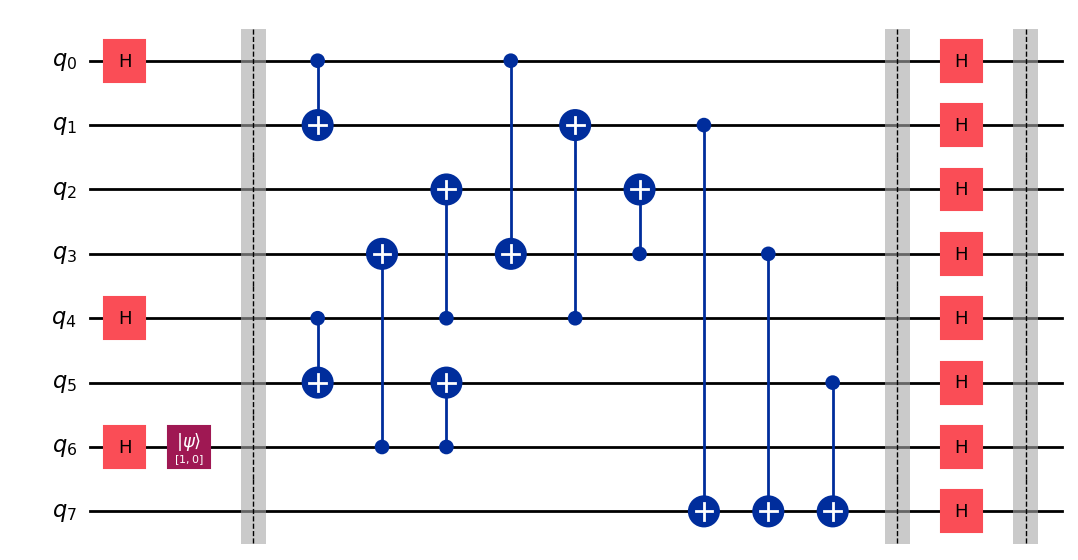

In [249]:
steane_enc_block_noise = QuantumCircuit(8, name="steane_block_noise")

steane_enc_block_noise.h(0)
steane_enc_block_noise.h(4)
steane_enc_block_noise.h(6)

#steane_enc_block.initialize([amp_0, amp_1], 6)
steane_enc_block_noise.initialize([amp_0, amp_1], 6)

steane_enc_block_noise.barrier()

steane_enc_block_noise.cx(0, 1)
steane_enc_block_noise.cx(4, 5)
steane_enc_block_noise.cx(6, 3)

steane_enc_block_noise.cx(4,2)
steane_enc_block_noise.cx(6,5)

steane_enc_block_noise.cx(0,3)
steane_enc_block_noise.cx(4,1)

steane_enc_block_noise.cx(3,2)

steane_enc_block_noise.cx(1,7)
steane_enc_block_noise.cx(3,7)
steane_enc_block_noise.cx(5,7)

steane_enc_block_noise.barrier()

for i in range(0, 8):
    steane_enc_block_noise.h(i)
    #steane_enc_block.measure(i,0)
steane_enc_block_noise.barrier()
# steane_enc_block.measure(7,0)


steane_enc_block_noise.draw('mpl')

In [250]:
steane_block_instr_noise = steane_enc_block_noise.to_instruction()

In [251]:
# applies h to n qubits 
def create_h_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        h_block = QuantumCircuit(num, num, name="h_block")
    else:
        h_block = QuantumCircuit(num, name="h_block_noise")

    for i in range(0, num):
        h_block.h(i)

    # convert to instruction
    h_block_instr = h_block.to_instruction()
    return h_block_instr

In [252]:
# applies cz to n qubits
def create_cz_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        cz_block = QuantumCircuit(num*2, num*2, name="cz_block")
    else:
        cz_block = QuantumCircuit(num*2, name="cz_block_noise")
    
    for i in range(0, num):
        cz_block.cz(i, i + num)
        print(num)

    # convert to instruction
    cz_block_instr = cz_block.to_instruction()
    return cz_block_instr

In [253]:
# applies identity to 7 qubits
def create_id_block(num: int, is_ideal: bool):

    if (is_ideal == 1):
        id_block = QuantumCircuit(num, num, name = "id_block")
    else:
        id_block = QuantumCircuit(num, name = "id_block")
    

    for i in range(0, num):
        id_block.id(i)

    id_block_instr = id_block.to_instruction()
    return id_block_instr

In [254]:
# applies x to 7 qubits
def create_x_block(num: int, is_ideal: bool):
    if (is_ideal == 1):
        x_block = QuantumCircuit(num, num, name = "x_block")
    else:
        x_block = QuantumCircuit(num, name = "x_block")
    

    for i in range(0, num):
        x_block.x(i)

    x_block_instr = x_block.to_instruction()
    return x_block_instr

In [255]:
def prepare_state(qc_prep: QuantumCircuit, encode_block: Instruction, log_block: Instruction, num: int, is_ideal: bool):

    if (is_ideal == 1):
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(encode_block, range(0,num), range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num), range(0,num))
        qc_prep.append(log_block,range(0,num), range(0,num))
        qc_prep.draw('mpl')
    else:
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(encode_block, range(0,num))
        qc_prep.append(create_id_block(num, is_ideal), range(0,num))
        qc_prep.append(log_block,range(0,num))
        qc_prep.draw('mpl')



In [256]:
state_arr_meas = []

qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr_meas = [qca, qcb, qcc]
counts_arr_meas = []

is_ideal = 1


for i in range(0,3): 

    prepare_state(qc_arr_meas[i], steane_block_instr, create_id_block(8,1), 8, is_ideal)

    #qc_arr[i].draw('mpl')
    for j in range(0,8):
        qc_arr_meas[i].measure(j,j)

    #qc_arr[i].measure(6,0)

    simulator = Aer.get_backend('statevector_simulator')
    steane_t = transpile(qc_arr_meas[i], simulator)
    job = simulator.run(steane_t, shots = 1000)
    result = job.result()
    counts = result.get_counts()
    state = result.get_statevector()
    state_arr_meas.append(state)
    counts_arr_meas.append(counts)
    #print(state)
    




c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


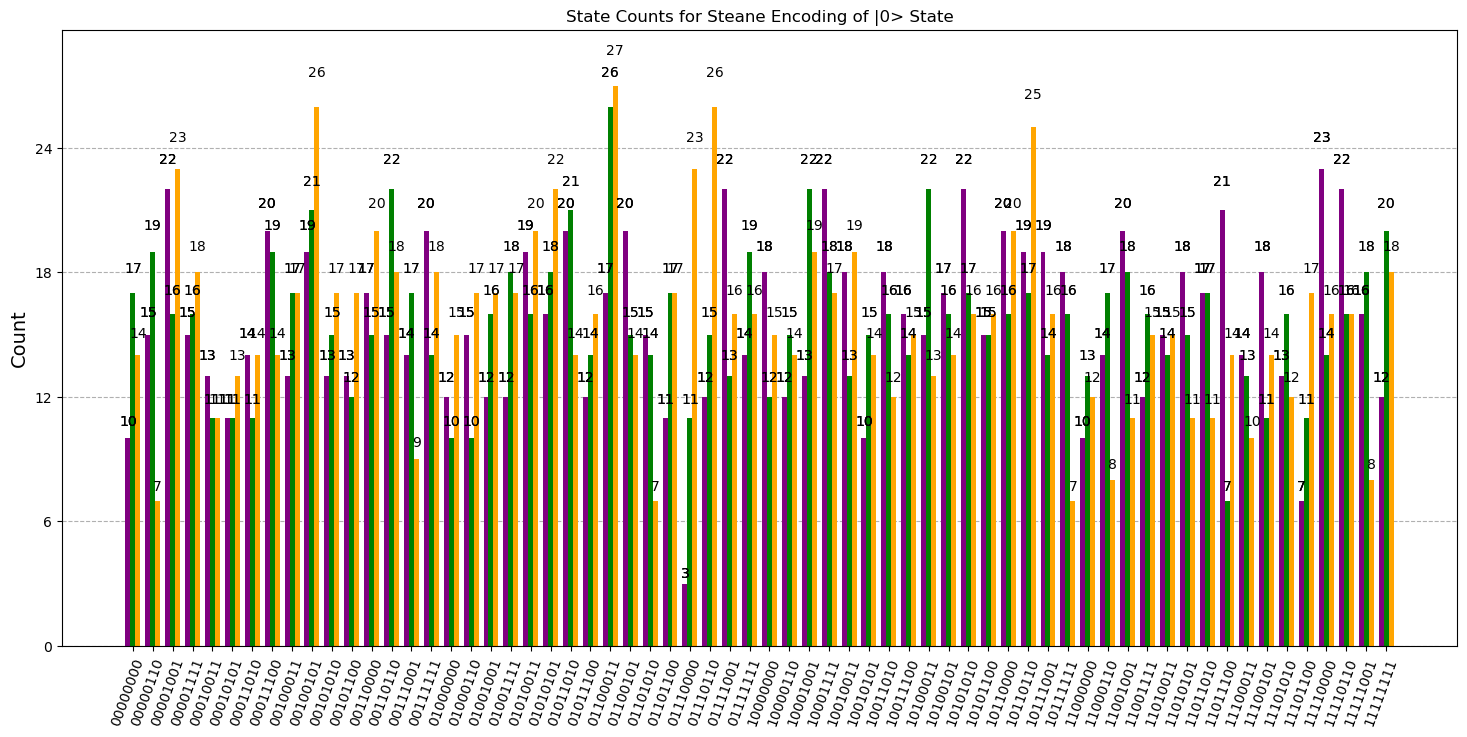

In [257]:
plot_histogram(counts_arr_meas, 
               figsize = (18, 8), 
               title = "State Counts for Steane Encoding of |0> State",
               color = ["purple", "green", "orange"])

In [277]:

state_arr = []

qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr = [qca, qcb, qcc]
counts_arr = []
is_ideal = 1



for i in range(0,3): 

    prepare_state(qc_arr[i], steane_block_instr, create_id_block(8, 1), 8, is_ideal)

    #qc_arr[i].draw('mpl')
    # for j in range(0,8):
    #     qc_arr[i].measure(j,j)

    #qc_arr[i].measure(6,0)

    simulator = Aer.get_backend('statevector_simulator')
    steane_t = transpile(qc_arr[i], simulator)
    job = simulator.run(steane_t, shots = 1000)
    result = job.result()
    #counts = result.get_counts()
    state = result.get_statevector()
    #print(len(state))
    state_arr.append(state)
    #counts_arr.append(counts)
    print(state)
    



#plot_histogram(counts_arr, figsize = (18, 8))
sv = Statevector([amp_0, amp_1])
print(sv)

#fid = state_fidelity(sv, Statevector(state_arr[0]))


fid_arr = []
err_arr = []
for z in state_arr[0]:
    state = np.array([np.sqrt(1 - abs(z)**2), z], dtype=np.complex128)
    svi = Statevector(state)
    fid = state_fidelity(sv, svi)
    #print(fid)
    err = 1 - fid
    fid_arr.append(fid)
    err_arr.append(err)

print([np.sqrt(1 - abs(z)**2), z])
# print(state_fidelity(sv, svi))

mean_err = np.mean(err_arr)
mean_fid = np.mean(fid_arr)

print(mean_err)


    








c:\Users\diyan\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


Statevector([ 1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.08056541e-33+1.5308085e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
             -4.48005088e-18+1.5308085e-17j,
              1.25000000e-01-4.5924255e-17j,
          

C:\Users\diyan\AppData\Local\Temp\ipykernel_38644\2735597240.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for z in state_arr[0]:


In [278]:
mean_err = np.mean(err_arr)

print(mean_err)
print(mean_fid)

0.0039062499999999722
0.99609375


In [260]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Fidelity Errors Preparing |0> State in the Steane Code')

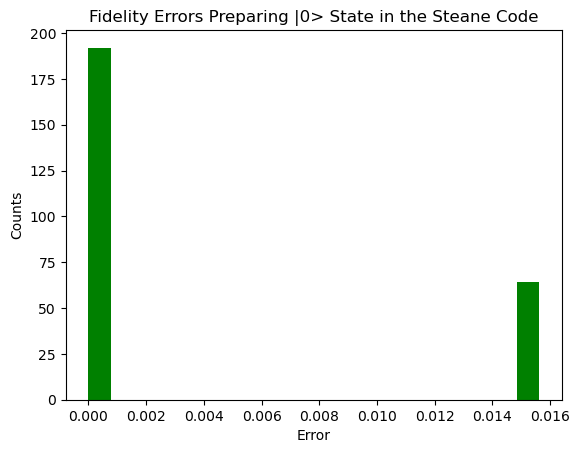

In [261]:

plt.hist(err_arr, bins = 20, color= 'green')
plt.xlabel("Error")
plt.ylabel("Counts")
plt.title("Fidelity Errors Preparing |0> State in the Steane Code")

The mean error rate is 0.39%, with the majority of shots having 100% fidelity

In [262]:
from qiskit.quantum_info import DensityMatrix

In [263]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

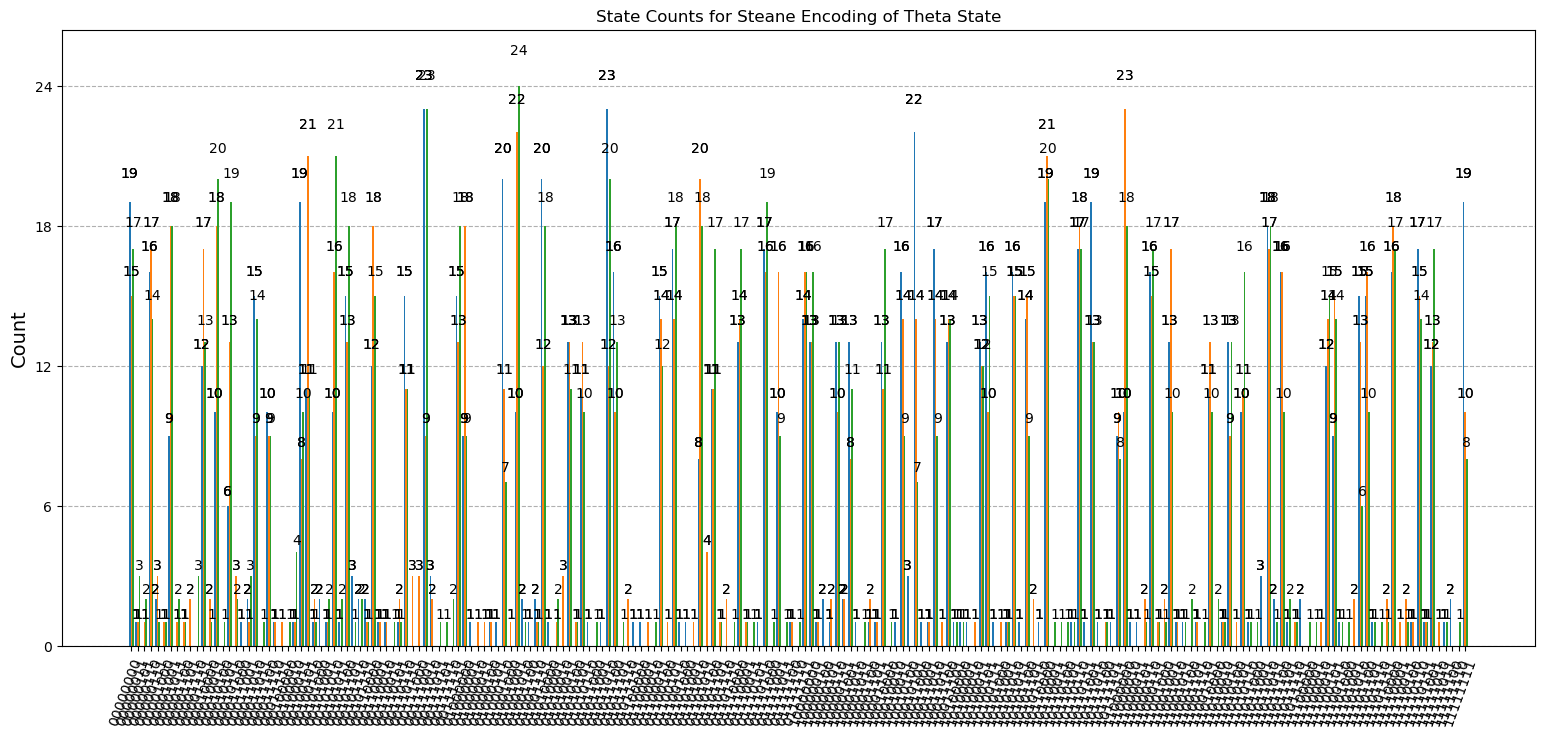

In [264]:


state_arr_n = []

qca_n = QuantumCircuit(8,8)
qcb_n = QuantumCircuit(8,8)
qcc_n = QuantumCircuit(8,8)

qc_arr_n = [qca_n, qcb_n, qcc_n]
is_ideal = 1
counts_arr_n = []




for i in range(0,3): 

    prepare_state(qc_arr_n[i], steane_block_instr, create_id_block(8, is_ideal), 8, is_ideal)


    
    #print(qc_clean)
    for j in range(0,8):
        # noise_model.add_readout_error(readout_err, [j])
        qc_arr_n[i].measure(j,j)

    #qc_arr_n[i].measure(6,0)
    backend = AerSimulator(noise_model=noise_model)

    transpiled = transpile(qc_arr_n[i], backend)

    
    #print(transpiled)

    job = backend.run(transpiled, shots = 1000)
    
    result = job.result()

    #print(result.data(0))
    counts_n = result.get_counts()

    # state_n = result.data(0)['density_matrix'] 
    # state_n_matrix = DensityMatrix(state_n) 
    #print(len(state))
    # state_arr_n.append(state_n_matrix)

    counts_arr_n.append(counts_n)
    #print(state)
    

smol_counts_arr_n = []


plot_histogram(counts_arr_n, figsize = (19, 8), title = "State Counts for Steane Encoding of Theta State")




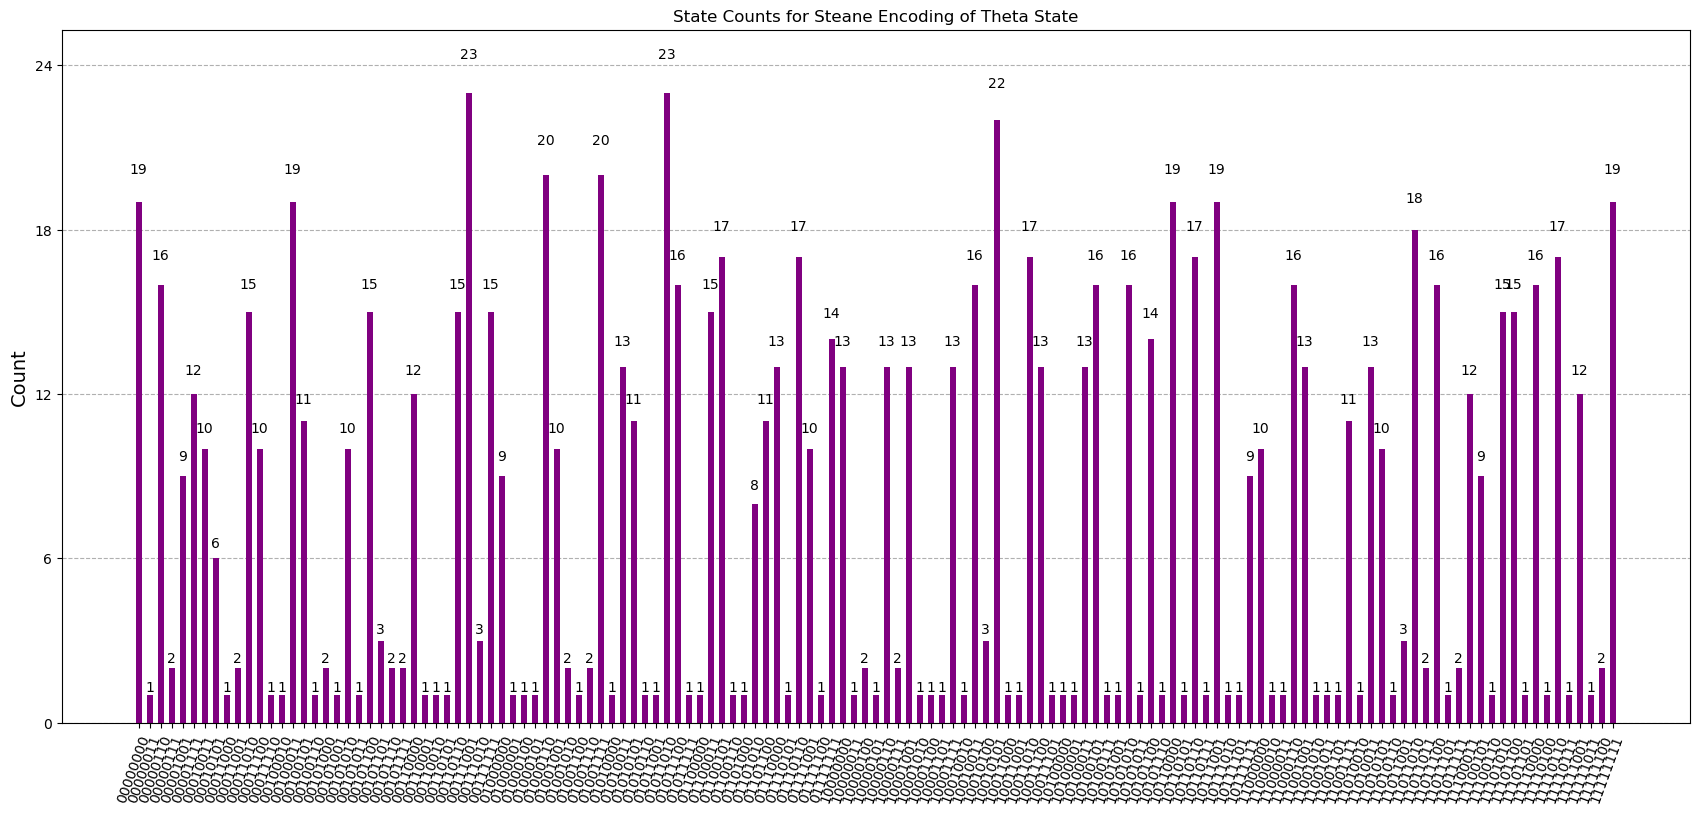

In [265]:
plot_histogram(counts_arr_n[0], 
               figsize = (21, 9), 
               title = "State Counts for Steane Encoding of Theta State",
               color = "purple")


In [266]:
# plt.hist(err_arr, bins = 20, color= 'red')
# plt.xlabel("Error")
# plt.ylabel("Counts")
# plt.title("Fidelity Errors Preparing Theta State in the Steane Code")

In [267]:
from collections import defaultdict
import numpy as np

def fidelity_from_counts(counts_ideal, counts_noisy):
    # Normalize to probabilities
    total_ideal = sum(counts_ideal.values())
    total_noisy = sum(counts_noisy.values())

    p = defaultdict(float, {k: v / total_ideal for k, v in counts_ideal.items()})
    q = defaultdict(float, {k: v / total_noisy for k, v in counts_noisy.items()})

    # Get all keys
    all_keys = set(p) | set(q)

    # Bhattacharyya coefficient
    bc = sum(np.sqrt(p[k] * q[k]) for k in all_keys)
    return bc ** 2  # fidelity minimum bound

## Fidelity of |0>

In [268]:

mean_arr_fid = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_meas[i], counts_arr_n[i])
    mean_arr_fid.append(ffc)


print(mean_arr_fid)
print(np.mean(mean_arr_fid))



[0.8773345032570308, 0.8760777587003856, 0.8656707108243614]
0.873027657593926


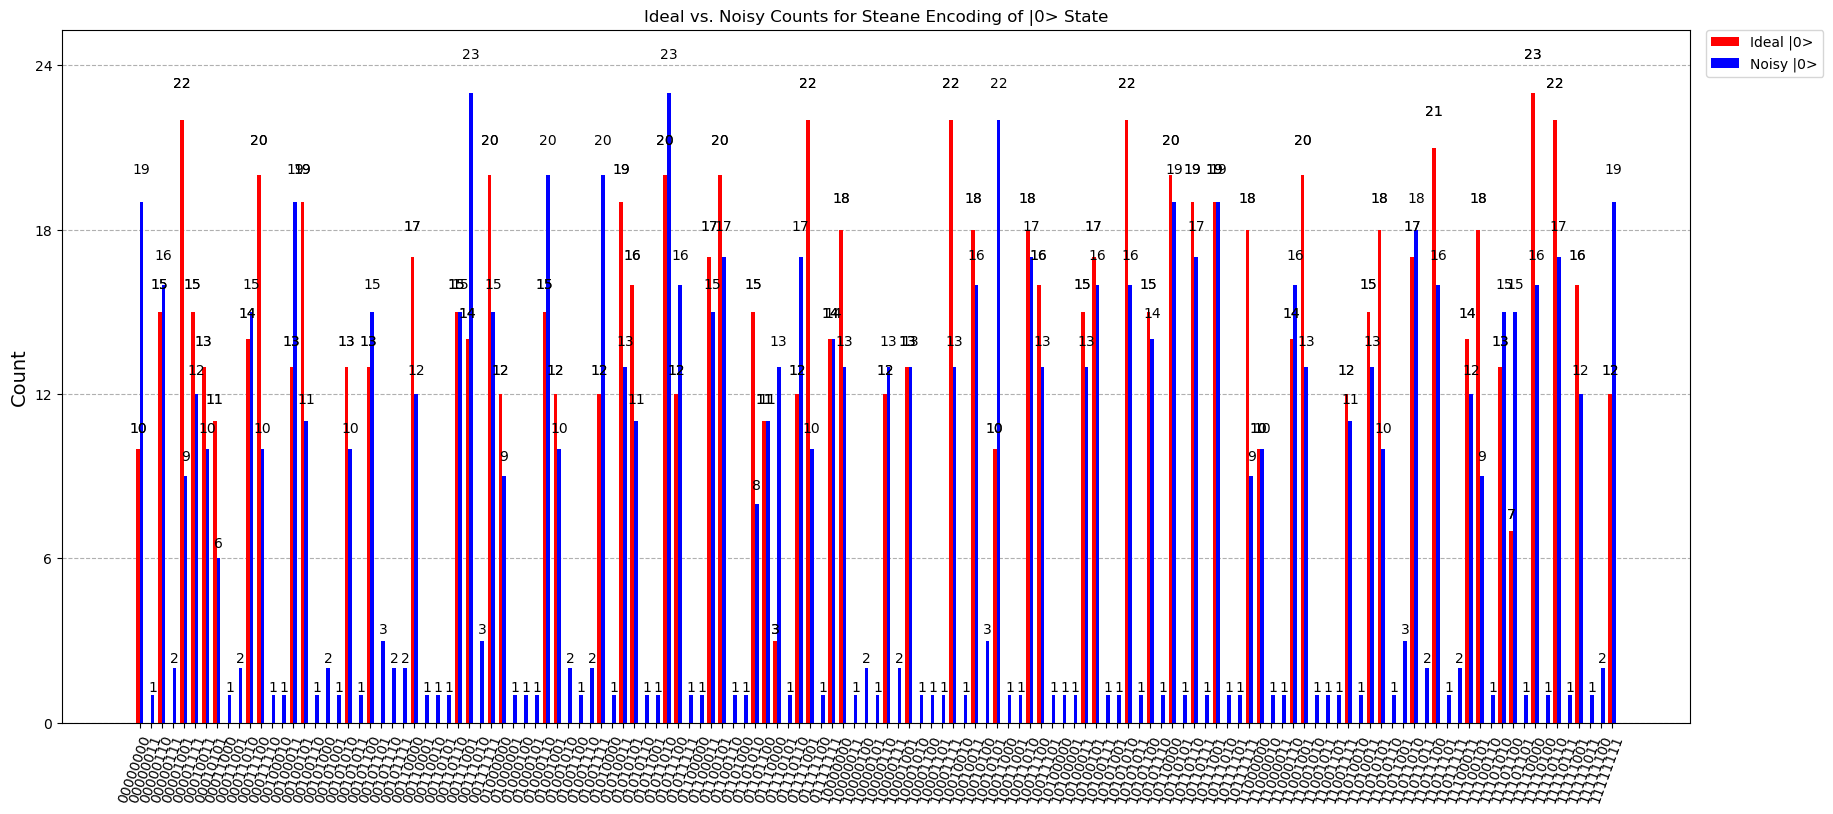

In [269]:
plot_histogram([counts_arr_meas[0], counts_arr_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of |0> State", 
               bar_labels = True, 
               legend=['Ideal |0>', 'Noisy |0>'],
               color = ["red", "blue"])

# Testing Theta state

Now we test the theta state! We should obtain a similar fidelity

In [270]:

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0_theta = np.cos(theta/2)
amp_1_theta = np.sin(theta/2)

print(Statevector([amp_0_theta, amp_1_theta]))

steane_intr_theta = steane_enc_q_c(amp_0_theta, amp_1_theta)

Statevector([0.94502682+0.j, 0.32699283+0.j],
            dims=(2,))


In [271]:
state_arr_theta = []

qca = QuantumCircuit(8,8)
qcb = QuantumCircuit(8,8)
qcc = QuantumCircuit(8,8)

qc_arr_theta = [qca, qcb, qcc]
counts_arr_theta = []

is_ideal = 1


for i in range(0,3): 

    prepare_state(qc_arr_theta[i], steane_intr_theta, create_id_block(8,1), 8, is_ideal)

    #qc_arr[i].draw('mpl')
    for j in range(0,8):
        qc_arr_theta[i].measure(j,j)

    #qc_arr[i].measure(6,0)

    simulator = Aer.get_backend('statevector_simulator')
    steane_t = transpile(qc_arr_theta[i], simulator)
    job = simulator.run(steane_t, shots = 1000)
    result = job.result()
    counts = result.get_counts()
    state = result.get_statevector()
    state_arr_theta.append(state)
    counts_arr_theta.append(counts)
    #print(state)
    



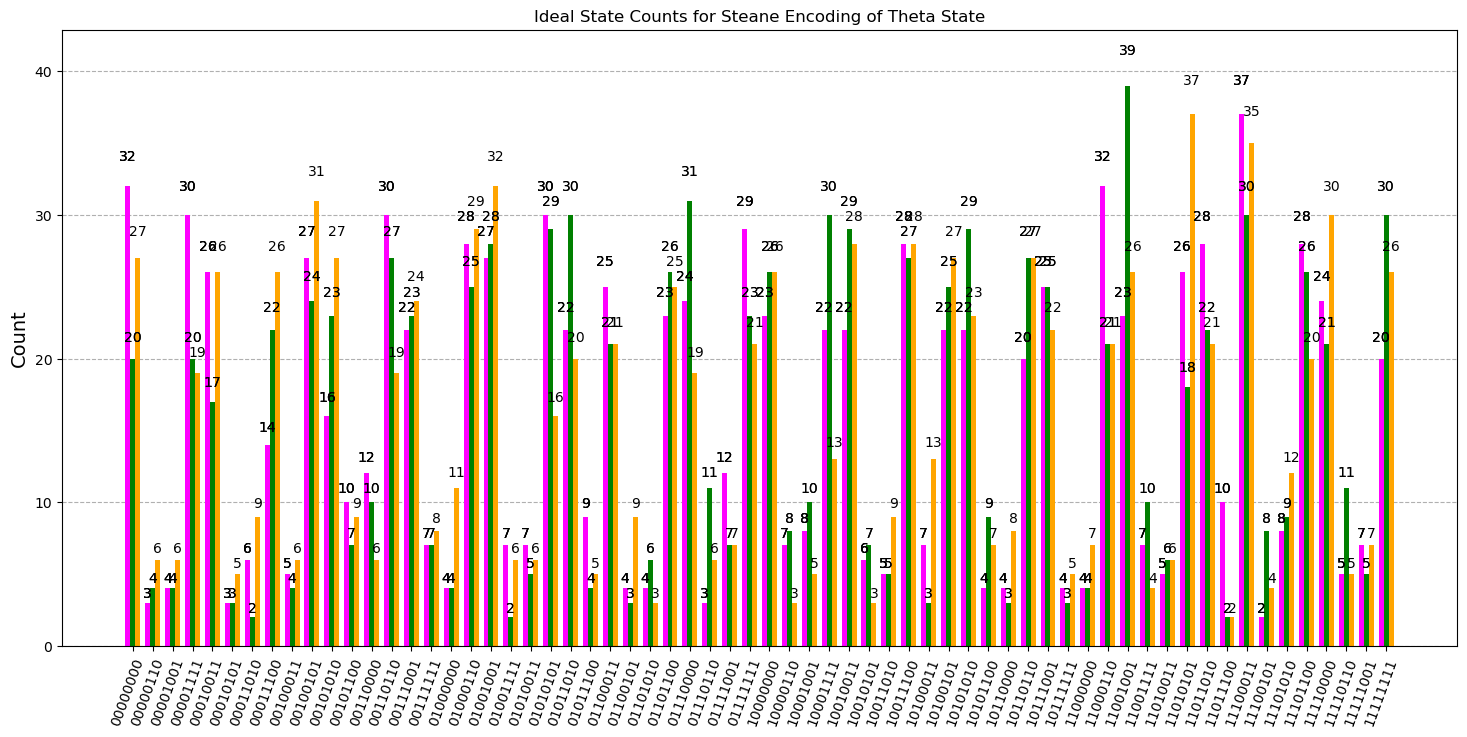

In [272]:
plot_histogram(counts_arr_theta, 
               figsize = (18, 8), 
               title = "Ideal State Counts for Steane Encoding of Theta State",
               color = ["magenta", "green", "orange"])

In [273]:


state_arr_theta_n = []

qca_n = QuantumCircuit(8,8)
qcb_n = QuantumCircuit(8,8)
qcc_n = QuantumCircuit(8,8)

qc_arr_theta_n = [qca_n, qcb_n, qcc_n]
is_ideal = 1
counts_arr_theta_n = []




for i in range(0,3): 

    prepare_state(qc_arr_theta_n[i], steane_intr_theta, create_id_block(8, is_ideal), 8, is_ideal)


    
    #print(qc_clean)
    for j in range(0,8):
        # noise_model.add_readout_error(readout_err, [j])
        qc_arr_theta_n[i].measure(j,j)

    #qc_arr_n[i].measure(6,0)
    backend = AerSimulator(noise_model=noise_model)

    transpiled = transpile(qc_arr_theta_n[i], backend)

    
    #print(transpiled)

    job = backend.run(transpiled, shots = 1000)
    
    result = job.result()

    #print(result.data(0))
    counts_theta_n = result.get_counts()

    # state_n = result.data(0)['density_matrix'] 
    # state_n_matrix = DensityMatrix(state_n) 
    #print(len(state))
    # state_arr_n.append(state_n_matrix)

    counts_arr_theta_n.append(counts_theta_n)
    #print(state)
    






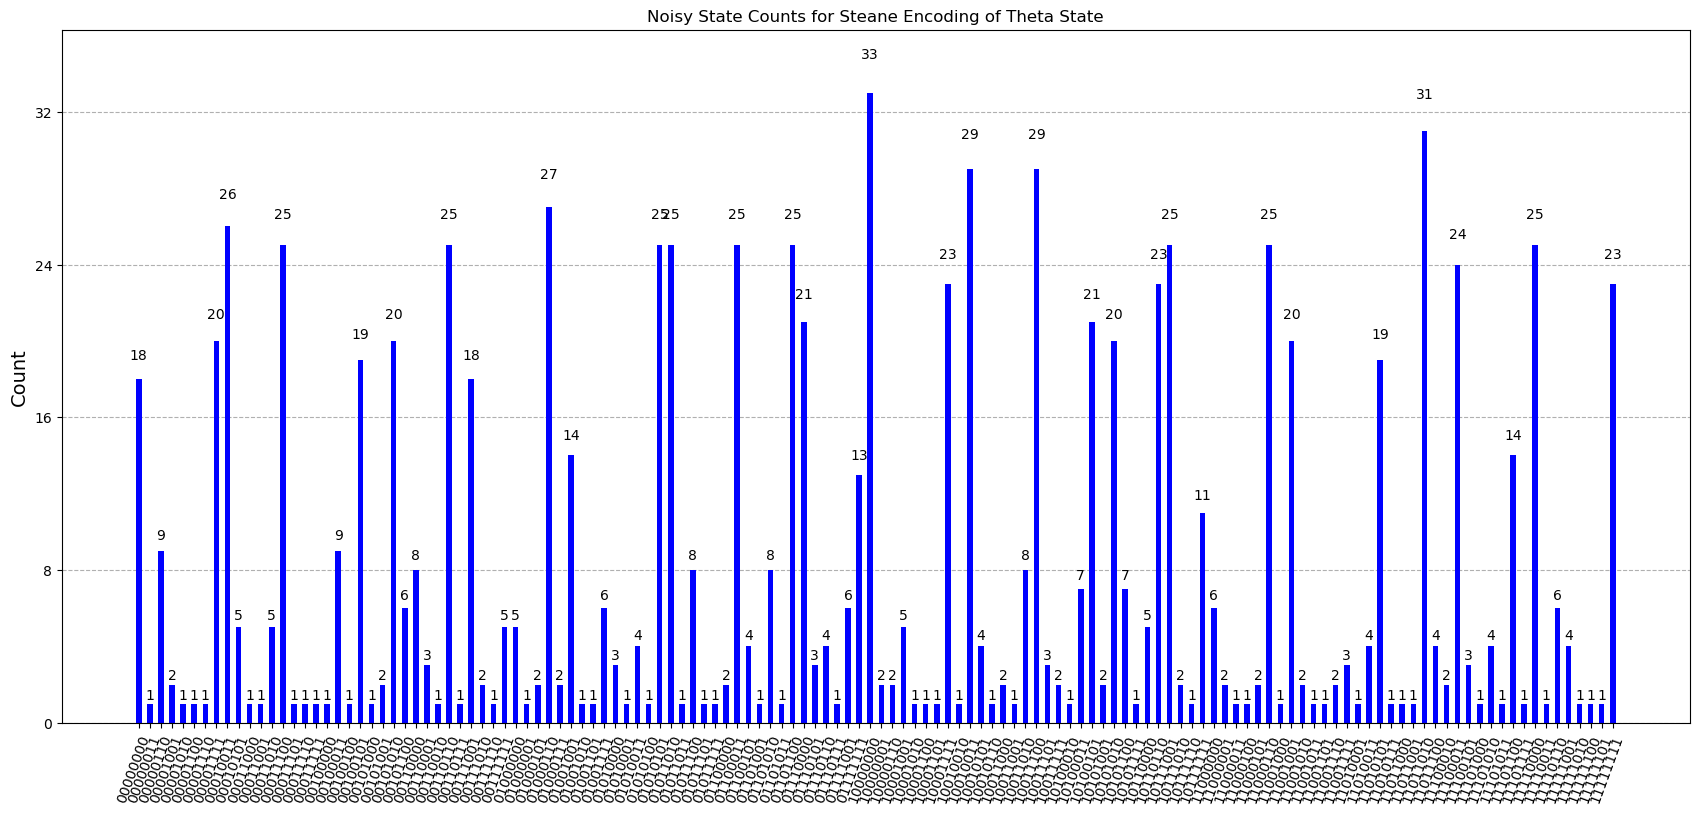

In [274]:
plot_histogram(counts_arr_theta_n[0], 
               figsize = (21, 9), 
               title = "Noisy State Counts for Steane Encoding of Theta State", 
               bar_labels = True,
               color = "blue")

## Fidelity of Theta State

In [275]:
mean_arr_theta_fid = []
err_arr_theta = []
for i in range(0,3):
    ffc = fidelity_from_counts(counts_arr_theta[i], counts_arr_theta_n[i])
    mean_arr_theta_fid.append(ffc)
    err_arr_theta.append(1 - ffc)



print(mean_arr_theta_fid)
print(np.mean(mean_arr_theta_fid))

[0.8780528386258474, 0.8547041452713128, 0.8615064027864331]
0.8647544622278645


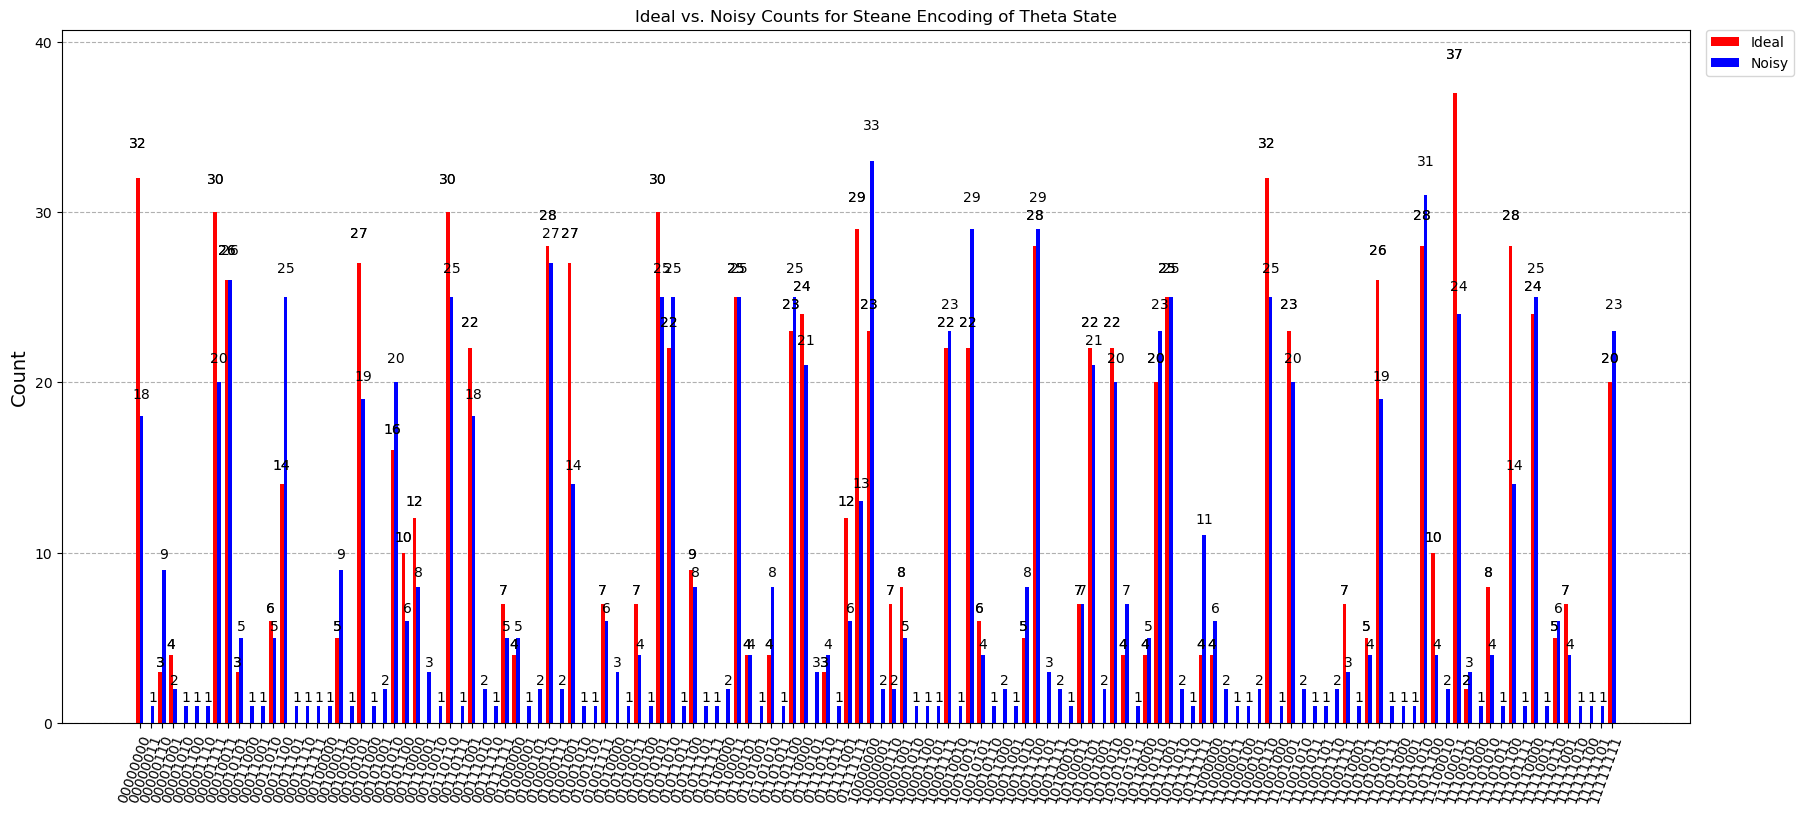

In [276]:
plot_histogram([counts_arr_theta[0], counts_arr_theta_n[0]], 
               figsize = (21, 9), 
               title = "Ideal vs. Noisy Counts for Steane Encoding of Theta State", 
               bar_labels = True, 
               legend=['Ideal', 'Noisy'],
               color = ["red", "blue"])

